<a href="https://colab.research.google.com/github/yahya010/DocClustering/blob/Tristan_Working/SeniorDesignCode_02_28_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -U sentence-transformers cleanlab hdbscan umap umap-learn[plot] wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 30.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.2 MB/s eta 0:00:00
  Pre

In [3]:
# IMPORTS

from cleanlab.outlier import OutOfDistribution
from enum import Enum
import os
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from PIL import Image
from seg_algorithm import get_optimal_splits, get_segmented_sentences
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel
from umap.umap_ import INT32_MAX
from wordcloud import WordCloud
from gensim.scripts.glove2word2vec import glove2word2vec
import cleanlab
import hdbscan
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import sklearn.cluster as cluster
import string
import torch
import torch.nn.functional as F
import umap
import unicodedata
from gensim.models import KeyedVectors
from statistics import mean
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS
import csv
nltk.download('averaged_perceptron_tagger') 
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
# Constants
URL = "https://raw.githubusercontent.com/yahya010/DocClustering/main/Pres_Speeches/presidential_speeches.csv"
stop_words = set(stopwords.words('english')) # switched to sklearn as it is larger than nltk stopwords
dataset = pd.read_csv(URL)
p = 0.65 #increase p = no of segments decreases

# Initialization
SEPERATE_BY_PRES = False

# Pre-Processing
MIN_SENTENCE_WORDS = 5
PLOT_SPEECHLEN_HIST = True
MIN_SPEECH_SENTENCE_COUNT = 10 # 10 sentences needed for cleanlab embedding

# Cleanlab
OUTLIER_SCORE_CUTOFF = 0.5
Z_SCORE_CUTOFF = -1.501
PRINT_CLEANLAB_ANALYSIS = True


## REF: https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/nlp/nlp_tf-idf_clustering.ipynb#scrollTo=EbAMAIFFV_xh

# List of Presidents
class PresidentIndex(Enum):
  George_Washington = 0
  John_Adams = 1
  Thomas_Jefferson = 2
  James_Madison = 3
  James_Monroe = 4
  John_Quincy_Adams = 5
  Andrew_Jackson = 6
  Martin_Van_Buren = 7
  William_Harrison = 8
  John_Tyler = 9
  James_Polk = 10
  Zachary_Taylor = 11
  Millard_Fillmore = 12
  Franklin_Pierce = 13
  James_Buchanan = 14
  Abraham_Lincoln = 15
  Andrew_Johnson = 16
  Ulysses_Grant = 17
  Rutherford_Hayes = 18
  James_Garfield = 19
  Chester_Arthur = 20
  Grover_Cleveland_1 = 21
  Benjamin_Harrison = 22
  Grover_Cleveland_2 = 23
  William_McKinley = 24
  Theodore_Roosevelt = 25
  William_Taft = 26
  Woodrow_Wilson = 27
  Warren_Harding = 28
  Calvin_Coolidge = 29
  Herbert_Hoover = 30
  Franklin_Roosevelt = 31
  Harry_Truman = 32
  Dwight_Eisenhower = 33 
  John_Kennedy= 34
  Lyndon_Johnson = 35
  Richard_Nixon = 36
  Gerald_Ford = 37
  James_Carter = 38
  Ronald_Reagan = 39
  George_Bush_SR = 40
  William_Clinton = 41
  George_Bush = 42
  Barack_Obama = 43
  Donald_Trump = 44

# Set Presidents to use
PRESIDENTS = [PresidentIndex.Ronald_Reagan, PresidentIndex.George_Bush_SR, PresidentIndex.William_Clinton, PresidentIndex.George_Bush, PresidentIndex.Barack_Obama, PresidentIndex.Donald_Trump];
PRESIDENT_NAMES = [n.name for n in PRESIDENTS]

# Get stopwords, stemmer and lemmatizer
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
general_stopwords = ENGLISH_STOP_WORDS  # note: sklearn has a longer list than nltk.corpus.stopwords.words('english')
additional_stopwords = []


# Get data samples and associated president
speeches = []
speech_classes = []

## TODO: VERIFY ALL PRES NAMES MATCH
# Tested: Washington, Lincoln

for index, row in dataset.iterrows():
  underscoreName = row['President'].replace(' ', '_')
  
  if underscoreName in PRESIDENT_NAMES:
    speeches.append(row['Transcript'])
    speech_classes.append(PresidentIndex[underscoreName].value)

In [5]:
def z_score(data):
    """Calculates the z-scores for a given dataset."""
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = (data - mean) / std_dev
    return z_scores

Number of Speeches Processed: 128
Filtered 0 speeches (under 10 sentences in total length)


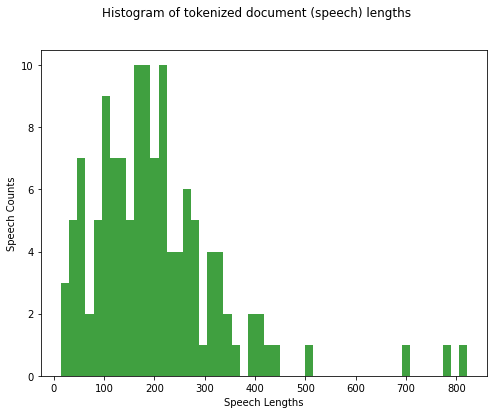

In [6]:
# Pre-Processing

pre_processed_speeches = []
list_token_lists = []


exclude = string.punctuation.replace(".", "")
exclude = exclude.replace("!", "")
exclude = exclude.replace("?", "")

# Pre-Processing Helpers
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")
  
def remove_misc(data):
  return data.replace('\n', '')

stop_words = set(stopwords.words('english'))
speech_lengths = []

for i, speech in enumerate(speeches):

  # Tokenize by sentence, then by lowercase word
  sent_count = 0
  pre_processed_speech_sentences = []

  for sentence in nltk.sent_tokenize(speech):
    token_list = []
    
    if len(nltk.word_tokenize(sentence)) < MIN_SENTENCE_WORDS:
      continue

    tokens = []
    sent_count += 1

    for word in nltk.word_tokenize(sentence):
      t = word.lower()
      t = remove_accents(t)
      t = remove_misc(t)
      t = str(t).translate(string.punctuation)
      t = t.translate(str.maketrans('', '', exclude))

      token_list.append(t)

    pre_processed_speech_sentences.append(' '.join(token_list)) # tokenized sentences
  
  if sent_count >= MIN_SPEECH_SENTENCE_COUNT:
    speech_lengths.append(sent_count)
    pre_processed_speeches.append(pre_processed_speech_sentences)
  
print(f'Number of Speeches Processed: {len(pre_processed_speeches)}')
print(f'Filtered {len(speeches) - len(pre_processed_speeches)} speeches (under 10 sentences in total length)')

df_speeches = pd.DataFrame(list_token_lists)

# Plot histogram of tokenized document lengths
if PLOT_SPEECHLEN_HIST:
  fig = plt.figure(figsize=(8,6))
  plt.suptitle("Histogram of tokenized document (speech) lengths")
  plt.xlabel("Speech Lengths")
  plt.ylabel("Speech Counts")
  n, bins, patches = plt.hist(speech_lengths, bins=50, density=False, facecolor='g', alpha=0.75)
  plt.show()

In [ ]:
# Running Cleanlab WITH z score removal
# Filters unrelated sentences from each individual speech

# Filtered speeches = list of every useful sentence across every speech of the selected president(s)
post_cleanlab_speeches = []
post_cleanlab_sentences = []
post_cleanlab_speeches_z_score = []
post_cleanlab_sentences_z_score = []

all_cleanlab_scores = []
all_z_scores = []

# Embedding and outlier removal
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

filtered_sent_percentages = []
filtered_sent_percentages_z_score = []

for i, speech in enumerate(pre_processed_speeches):
  try:
    ood = OutOfDistribution()
    original_embeddings = model.encode(speech)
    train_outlier_scores = ood.fit_score(features=original_embeddings)
    # get outlier id's for sentences with outlier scores below cutoff value
    outlier_ids = [i for i, outlier_score in enumerate(train_outlier_scores) if outlier_score < OUTLIER_SCORE_CUTOFF]
    # find z score for sentences and set z score cuttoff to determine what to remove
    z_scores = z_score(train_outlier_scores)
    outlier_ids_z_score = [i for i, outlier_score_z_score in enumerate(z_scores) if  outlier_score_z_score < Z_SCORE_CUTOFF]

    if PRINT_CLEANLAB_ANALYSIS:
      filtered_sentences = [s for i, s in enumerate(speech) if i in outlier_ids]
      filtered_percent = round((len(filtered_sentences) / len(speech)) * 100) 
      filtered_sent_percentages.append(filtered_percent)
       # z score filtered removal number
      filtered_sentences_z_score = [s for i, s in enumerate(speech) if i in outlier_ids_z_score]
      filtered_percent_z_score = round((len(filtered_sentences_z_score) / len(speech)) * 100) 
      filtered_sent_percentages_z_score.append(filtered_percent_z_score)

      # Metrics
      
      average_cleanlab_score = float(np.mean(train_outlier_scores))
      variance_cleanlab_score = float(sum((x - average_cleanlab_score)**2 for x in train_outlier_scores) / (len(train_outlier_scores) - 1))
      std_cleanlab_score = float(np.sqrt(variance_cleanlab_score))
      min_cleanlab_score = float(min(train_outlier_scores))
      max_cleanlab_score = float(max(train_outlier_scores))
      average_z_score = float(np.mean(z_scores))
      variance_z_score = float(sum((x - average_z_score)**2 for x in z_scores) / (len(z_scores) - 1))
      std_z_score = float(np.sqrt(variance_z_score))
      min_z_score = float(min(z_scores))
      max_z_score = float(max(z_scores))

      all_cleanlab_scores.extend(train_outlier_scores)
      all_z_scores.extend(z_scores)
      
      print(f'Speech: {i}')
      print("Cleanlab Metrics:")
      print(f'  Percent Sentences Filtered: {filtered_percent}% out of {len(speech)} Sentences')
      print(f'  Average: {round(average_cleanlab_score, 3)}')
      print(f'  Variance: {round(variance_cleanlab_score, 3)}')
      print(f'  STDev: {round(std_cleanlab_score, 3)}')
      print(f'  Min: {round(min_cleanlab_score, 3)}')
      print(f'  Max: {round(max_cleanlab_score, 3)}')
      print("Cleanlab with Z Score Metrics:")
      print(f'  Percent Sentences Filtered: {filtered_percent_z_score}% out of {len(speech)} Sentences')
      print(f'  Average: {round(average_z_score, 3)}')
      print(f'  Variance: {round(variance_z_score, 3)}')
      print(f'  STDev: {round(std_z_score, 3)}')
      print(f'  Min: {round(min_z_score, 3)}')
      print(f'  Max: {round(max_z_score, 3)}')
      print("Filtered Sentences:")
      for i, s in enumerate(filtered_sentences):
        print(f'  {i}: {s}')
      print("Filtered Sentences Z score:")
      for i, s in enumerate(filtered_sentences_z_score):
        print(f'  {i}: {s}')
      print("\n\n")

    speech_cleanlab = [s for i, s in enumerate(speech) if i not in outlier_ids]
    speech_z_score = [s for i, s in enumerate(speech) if i not in outlier_ids_z_score]

    post_cleanlab_speeches.append(speech_cleanlab)
    post_cleanlab_speeches_z_score.append(speech_z_score)

    for sentence in speech_cleanlab:
      post_cleanlab_sentences.append(sentence)
    for sentence in speech_z_score:
      post_cleanlab_speeches_z_score.append(sentence)
  except:
    continue

print(f'Cleanlab score: {all_cleanlab_scores}')
print(f'Z score: {all_z_scores}')

# Z score is currently being removed from the threshold found from each speech meaning the same percentage of lowest ranking scores are cut from every speech not matter the context. 
# We need to either combine the loop to go through them all at once and remove that percentage from the corpus or remover CL score thresholds from individual speeches.

# filtered_speech_embeddings = model.encode(post_cleanlab_sentences) # embedding
# filtered_speech_embeddings_z_score = model.encode(post_cleanlab_speeches_z_score)

# if PRINT_CLEANLAB_ANALYSIS:
#   # print(f'Unfiltered Speech Shape: {model.encode(pre_processed_speeches).shape}') vcc
#   print(f'Filtered Speech Shape: {filtered_speech_embeddings.shape}')
#   print(f'Filtered Speech Shape Z Score: {filtered_speech_embeddings_z_score.shape}')
#   print(f'Average percentage of filtered sentences per speech (cutoff value  of {OUTLIER_SCORE_CUTOFF}): {sum(filtered_sent_percentages) / len(filtered_sent_percentages)}')
#   print(f'Average percentage of filtered z score sentences per speech (cutoff value  of {Z_SCORE_CUTOFF}): {sum(filtered_sent_percentages_z_score) / len(filtered_sent_percentages_z_score)}')

Streaming output truncated to the last 5000 lines.

Fitting OOD estimator based on provided features ...
Speech: 33
Cleanlab Metrics:
  Percent Sentences Filtered: 7% out of 96 Sentences
  Average: 0.571
  Variance: 0.002
  STDev: 0.04
  Min: 0.46
  Max: 0.633
Cleanlab with Z Score Metrics:
  Percent Sentences Filtered: 11% out of 96 Sentences
  Average: -0.0
  Variance: 1.011
  STDev: 1.005
  Min: -2.801
  Max: 1.556
Filtered Sentences:
  0: two hundred and twentyfive came here 
  1: gentlemen  i look at you and i think of the words of stephen spender s poem 
  2: well  they were nt 
  3: why did you do it 
  4: we look at you  and somehow we know the answer 
  5: and you were right not to doubt 
  6: thank you very much  and god bless you all
Filtered Sentences Z score:
  0: two hundred and twentyfive came here 
  1: gentlemen  i look at you and i think of the words of stephen spender s poem 
  2: well  they were nt 
  3: yet  you risked everything here 
  4: why did you do it 
  5: 

In [ ]:
# Running Cleanlab WITH z score removal
# Filters unrelated sentences from each individual speech

# Filtered speeches = list of every useful sentence across every speech of the selected president(s)
post_cleanlab_speeches = []
post_cleanlab_sentences = []
post_cleanlab_speeches_z_score = []
post_cleanlab_sentences_z_score = []

all_cleanlab_scores = []
all_z_scores = []

# Embedding and outlier removal
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

filtered_sent_percentages = []
filtered_sent_percentages_z_score = []

for i, speech in enumerate(pre_processed_speeches):
  try:
    ood = OutOfDistribution()
    original_embeddings = model.encode(speech)
    train_outlier_scores = ood.fit_score(features=original_embeddings)
    # get outlier id's for sentences with outlier scores below cutoff value
    outlier_ids = [i for i, outlier_score in enumerate(train_outlier_scores) if outlier_score < OUTLIER_SCORE_CUTOFF]
    # find z score for sentences and set z score cuttoff to determine what to remove
    z_scores = z_score(train_outlier_scores)
    outlier_ids_z_score = [i for i, outlier_score_z_score in enumerate(z_scores) if  outlier_score_z_score < Z_SCORE_CUTOFF]

    if PRINT_CLEANLAB_ANALYSIS:
      filtered_sentences = [s for i, s in enumerate(speech) if i in outlier_ids]
      filtered_percent = round((len(filtered_sentences) / len(speech)) * 100) 
      filtered_sent_percentages.append(filtered_percent)
       # z score filtered removal number
      filtered_sentences_z_score = [s for i, s in enumerate(speech) if i in outlier_ids_z_score]
      filtered_percent_z_score = round((len(filtered_sentences_z_score) / len(speech)) * 100) 
      filtered_sent_percentages_z_score.append(filtered_percent_z_score)

      # Metrics
      
      average_cleanlab_score = float(np.mean(train_outlier_scores))
      variance_cleanlab_score = float(sum((x - average_cleanlab_score)**2 for x in train_outlier_scores) / (len(train_outlier_scores) - 1))
      std_cleanlab_score = float(np.sqrt(variance_cleanlab_score))
      min_cleanlab_score = float(min(train_outlier_scores))
      max_cleanlab_score = float(max(train_outlier_scores))
      average_z_score = float(np.mean(z_scores))
      variance_z_score = float(sum((x - average_z_score)**2 for x in z_scores) / (len(z_scores) - 1))
      std_z_score = float(np.sqrt(variance_z_score))
      min_z_score = float(min(z_scores))
      max_z_score = float(max(z_scores))

      all_cleanlab_scores.extend(train_outlier_scores)
      all_z_scores.extend(z_scores)
      
      print(f'Speech: {i}')
      print("Cleanlab Metrics:")
      print(f'  Percent Sentences Filtered: {filtered_percent}% out of {len(speech)} Sentences')
      print(f'  Average: {round(average_cleanlab_score, 3)}')
      print(f'  Variance: {round(variance_cleanlab_score, 3)}')
      print(f'  STDev: {round(std_cleanlab_score, 3)}')
      print(f'  Min: {round(min_cleanlab_score, 3)}')
      print(f'  Max: {round(max_cleanlab_score, 3)}')
      print("Cleanlab with Z Score Metrics:")
      print(f'  Percent Sentences Filtered: {filtered_percent_z_score}% out of {len(speech)} Sentences')
      print(f'  Average: {round(average_z_score, 3)}')
      print(f'  Variance: {round(variance_z_score, 3)}')
      print(f'  STDev: {round(std_z_score, 3)}')
      print(f'  Min: {round(min_z_score, 3)}')
      print(f'  Max: {round(max_z_score, 3)}')
      print("Filtered Sentences:")
      for i, s in enumerate(filtered_sentences):
        print(f'  {i}: {s}')
      print("Filtered Sentences Z score:")
      for i, s in enumerate(filtered_sentences_z_score):
        print(f'  {i}: {s}')
      print("\n\n")

    speech_cleanlab = [s for i, s in enumerate(speech) if i not in outlier_ids]
    speech_z_score = [s for i, s in enumerate(speech) if i not in outlier_ids_z_score]

    post_cleanlab_speeches.append(speech_cleanlab)
    post_cleanlab_speeches_z_score.append(speech_z_score)

    for sentence in speech_cleanlab:
      post_cleanlab_sentences.append(sentence)
    for sentence in speech_z_score:
      post_cleanlab_speeches_z_score.append(sentence)
  except:
    continue

print(f'Cleanlab score: {all_cleanlab_scores}')
print(f'Z score: {all_z_scores}')


In [ ]:
      average_cleanlab_score = float(np.mean(all_cleanlab_scores))
      variance_cleanlab_score = float(sum((x - average_cleanlab_score)**2 for x in all_cleanlab_scores) / (len(all_cleanlab_scores) - 1))
      std_cleanlab_score = float(np.sqrt(variance_cleanlab_score))
      min_cleanlab_score = float(min(all_cleanlab_scores))
      max_cleanlab_score = float(max(all_cleanlab_scores))
      average_z_score = float(np.mean(all_z_scores))
      variance_z_score = float(sum((x - average_z_score)**2 for x in all_z_scores) / (len(all_z_scores) - 1))
      std_z_score = float(np.sqrt(variance_z_score))
      min_z_score = float(min(all_z_scores))
      max_z_score = float(max(all_z_scores))
      print("Cleanlab Metrics:")
      print(f'  Average: {round(average_cleanlab_score, 3)}')
      print(f'  Variance: {round(variance_cleanlab_score, 3)}')
      print(f'  STDev: {round(std_cleanlab_score, 3)}')
      print(f'  Min: {round(min_cleanlab_score, 3)}')
      print(f'  Max: {round(max_cleanlab_score, 3)}')
      print("Cleanlab with Z Score Metrics:")
      print(f'  Average: {round(average_z_score, 3)}')
      print(f'  Variance: {round(variance_z_score, 3)}')
      print(f'  STDev: {round(std_z_score, 3)}')
      print(f'  Min: {round(min_z_score, 3)}')
      print(f'  Max: {round(max_z_score, 3)}')

Cleanlab Metrics:
  Average: 0.583
  Variance: 0.003
  STDev: 0.057
  Min: 0.389
  Max: 1.0
Cleanlab with Z Score Metrics:
  Average: -0.0
  Variance: 1.0
  STDev: 1.0
  Min: -4.212
  Max: 4.984


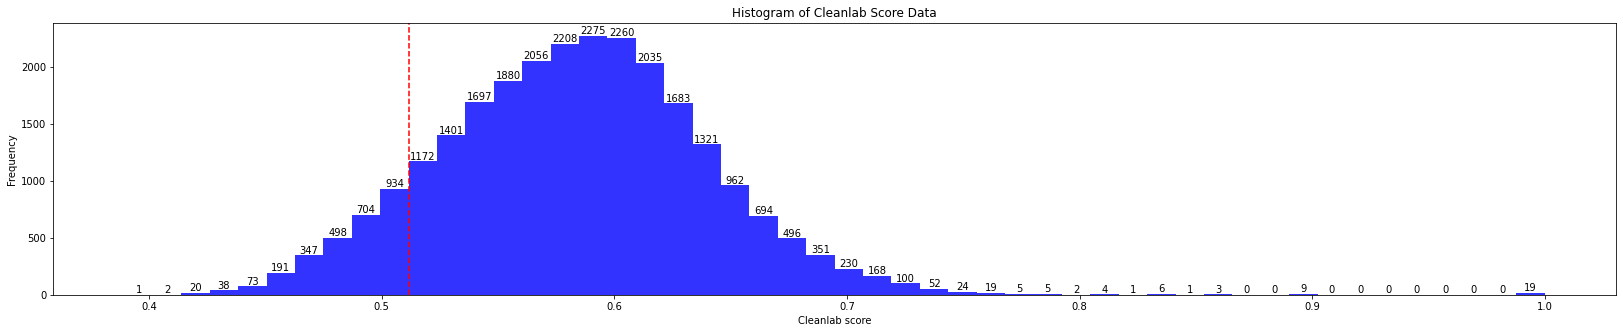

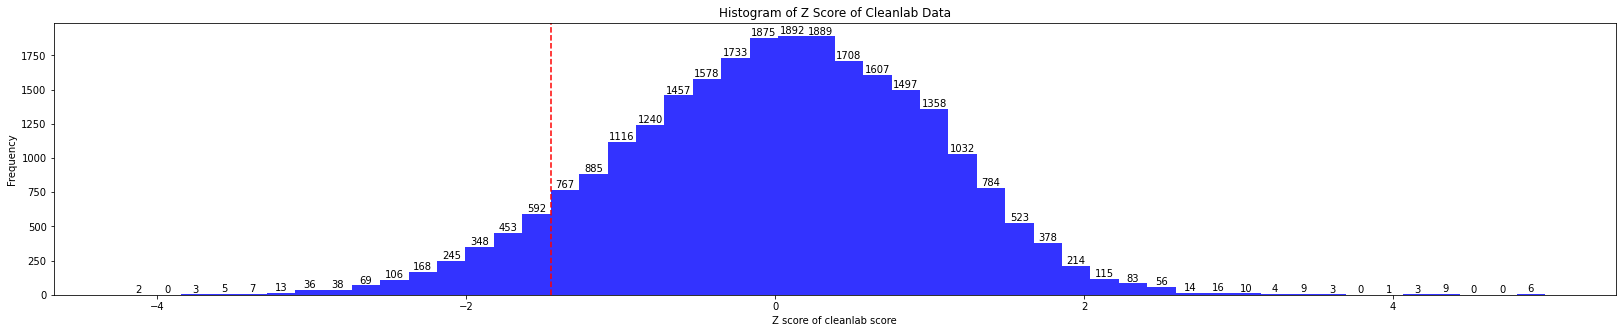

Cleanlab
  Smallest Cleanlab Number Score: 0.5
  Percent Filtered Out: 7.4%
Z Score
  Smallest Z Score Number Score: -1.501
  Percent Filtered Out: 7.4%


In [ ]:
# Cleanlab and Z score Histogram

cleanlab_histogram_cutoff = 0.5
num_bins = 50

# Cleanlab Histogram
fig = plt.figure(figsize=(28, 5))
n, bins, patches = plt.hist(all_cleanlab_scores, bins=num_bins, color='blue', alpha=0.8) # alpha is transparency of bars
sorted_data = np.sort(all_cleanlab_scores)
count = len([x for x in sorted_data if x < cleanlab_histogram_cutoff])
# val = np.min(sorted_data[n_smallest_num - 1])
idx = np.searchsorted(bins, cleanlab_histogram_cutoff, side='left')
x = bins[idx]
plt.axvline(x=x, color='red', linestyle='--')
plt.xlabel('Cleanlab score')
plt.ylabel('Frequency')
plt.title('Histogram of Cleanlab Score Data')
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width()/2.0, patches[i].get_height(),
             int(n[i]), ha='center', va='bottom')
plt.show()

# Cleanlab with Z Score Histogram
fig = plt.figure(figsize=(28, 5))
n, bins, patches = plt.hist(all_z_scores, bins=num_bins, color='blue', alpha=0.8) # alpha is transparency of bars
sorted_data = np.sort(all_z_scores)
z_score_histogram_cutoff = np.min(sorted_data[count - 1])
z_score_count = len([x for x in sorted_data if x < z_score_histogram_cutoff])
idx = np.searchsorted(bins, z_score_histogram_cutoff, side='left')
x = bins[idx]
plt.axvline(x=x, color='red', linestyle='--')
plt.xlabel('Z score of cleanlab score')
plt.ylabel('Frequency')
plt.title('Histogram of Z Score of Cleanlab Data')
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width()/2.0, patches[i].get_height(),
             int(n[i]), ha='center', va='bottom')
plt.show()
print(f'Cleanlab')
print(f'  Smallest Cleanlab Number Score: {cleanlab_histogram_cutoff}')
print(f'  Percent Filtered Out: {round(float((count/len(all_cleanlab_scores))*100),2)}%')

print(f'Z Score')
print(f'  Smallest Z Score Number Score: {round(float(z_score_histogram_cutoff),3)}')
print(f'  Percent Filtered Out: {round(float((z_score_count/len(all_z_scores))*100),2)}%')


In [ ]:
# PCA-95 Dimensionality Reduction
pca = PCA(n_components=0.95)
reduced_embedding = pca.fit_transform([f for f in filtered_speech_embeddings])
print(reduced_embedding.shape)

(4568, 285)


In [ ]:
# PCA-95 Dimensionality Reduction of Z-Score Filtered
# pca = PCA(n_components=0.95)
# reduced_embedding = pca.fit_transform([f for f in filtered_speech_embeddings_z_score])
# print(reduced_embedding.shape)

(735, 218)


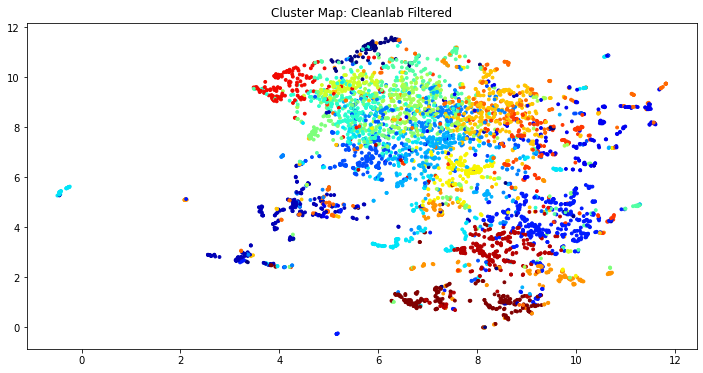

(4568, 285)


In [ ]:
# #Umap Clustering

# reducer = umap.UMAP(n_components=2)
# sentences_embeddings_reduced = reducer.fit_transform(filtered_speech_embeddings)

# # Apply KMeans clustering to the reduced embeddings
# kmeans = KMeans(n_clusters=10)
# kmeans.fit(sentences_embeddings_reduced)

# # Get the cluster labels for each sentence
# labels = kmeans.labels_
# plt.scatter(sentences_embeddings_reduced[:, 0], sentences_embeddings_reduced[:, 1], c=labels)
# plt.xlabel('Dimension 2 Score')
# plt.ylabel('Dimension 1 Score')
# plt.show()

# UMAP Clustering
reducer = umap.UMAP(n_components=2)
sentences_embeddings_reduced = reducer.fit_transform(reduced_embedding)

# Apply KMeans clustering to the reduced embeddings
kmeans = KMeans(n_clusters=21)
kmeans.fit(reduced_embedding)

# Get the cluster labels for each sentence and plot
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(12, 6))
plt.title("Cluster Map: Cleanlab Filtered")
plt.scatter(sentences_embeddings_reduced[:, 0], sentences_embeddings_reduced[:, 1], c=labels, cmap='jet', s=8) # s = dot size, cmap variables include cmap = 'jet', 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
# plt.xlim(6,14)  # Limits x axis range
# plt.ylim(0,10)  # Limits y axis range
plt.show()

# Does the two dimensions just represent the visual cluster comparison? KMeans is nonlinear

print(reduced_embedding.shape)

In [ ]:
# Segmentation
segmentation  = get_optimal_splits(filtered_speech_embeddings, p) # Splits.
segmented_txt = get_segmented_sentences(post_cleanlab_sentences, segmentation)
segment_list = []
for segment in segmented_txt:
    segment_list.append('Segment ' + str(segmented_txt.index(segment)) + ': ' + str(segment))

seglistDF = pd.DataFrame(segment_list)
seglistDF.to_csv('fullSegmentationList.csv')

In [ ]:
def squared_sum(x):
  """ return 3 rounded square rooted value """
  return round(np.sqrt(sum([a*a for a in x])),3)

def cos_similarity(x,y):
  """ return cosine similarity between two lists """
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

In [ ]:
def color_func(word=None, font_size=None,
                     position=None, orientation=None,
                     font_path=None, random_state=None):
    colors = [[4, 77, 82],
              [25, 74, 85],
              [82, 43, 84],
              [158, 48, 79]]
    rand = random_state.randint(0, len(colors) - 1)
    return "hsl({}, {}%, {}%)".format(colors[rand][0], colors[rand][1], colors[rand][2])

['disapprobation', 'lear', 'postmaster', 'printers', 'representations', 'gotten', 'lacking', 'lengths', 'lick', 'mill', 'mortices', 'omitting', 'tenons', 'workmen', 'accustoming', 'actively', 'alienate', 'artifices', 'collective', 'covertly', 'dawning', 'discountenancing', 'foresee', 'fortress', 'frowning', 'immovable', 'indignantly', 'infinite', 'insidiously', 'link', 'palladium', 'ad', 'eighth', 'offor', 'diversifying', 'gentle', 'ingratitude', 'preferences', 'dispense', 'amsterdam', 'antwerp', 'achieve', 'bind', 'bondsman', 'charity', 'finish', 'lash', 'lord', 'orphan', 'sunk']


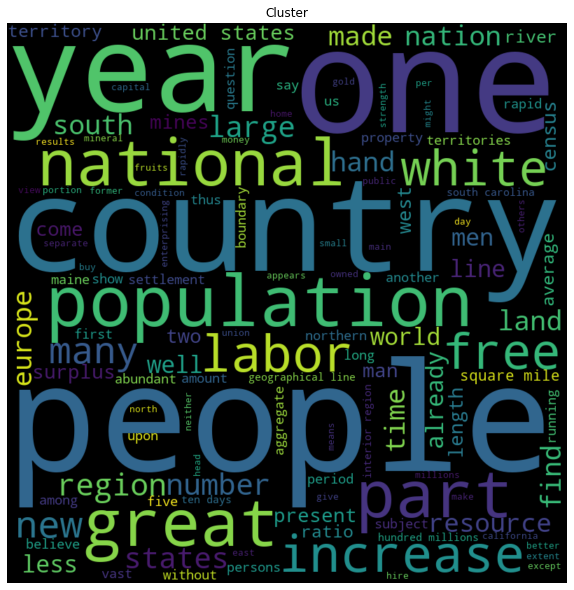

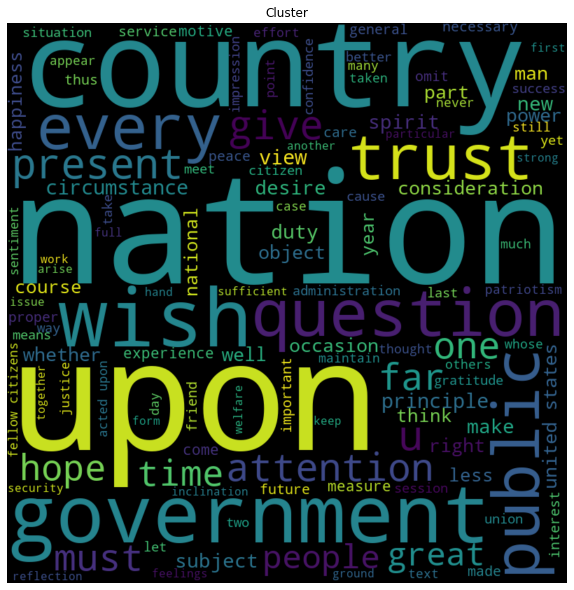

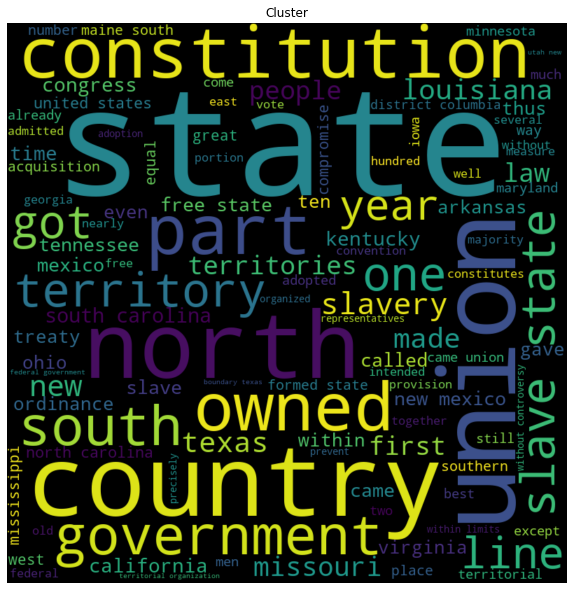

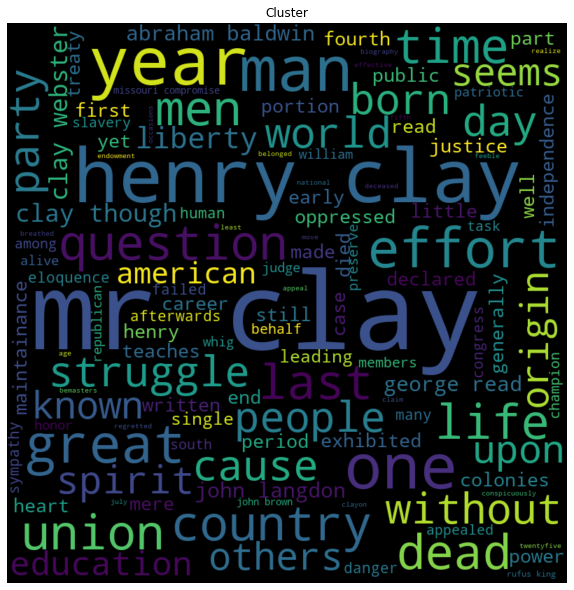

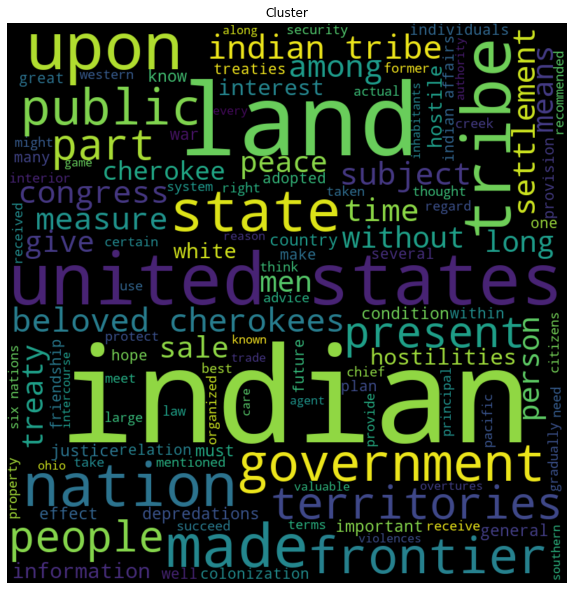

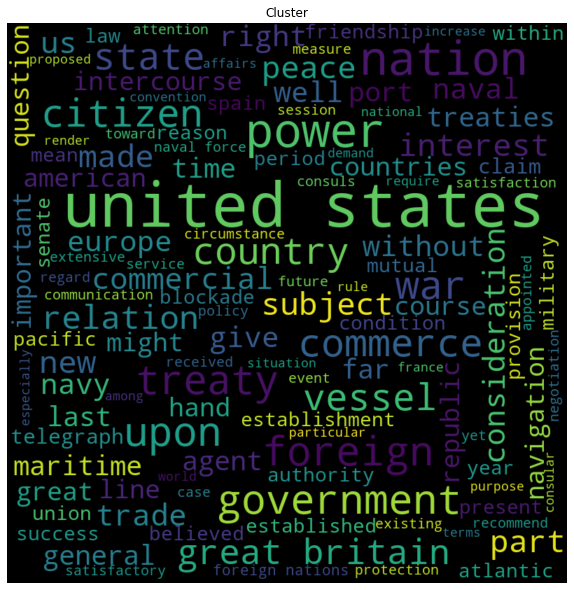

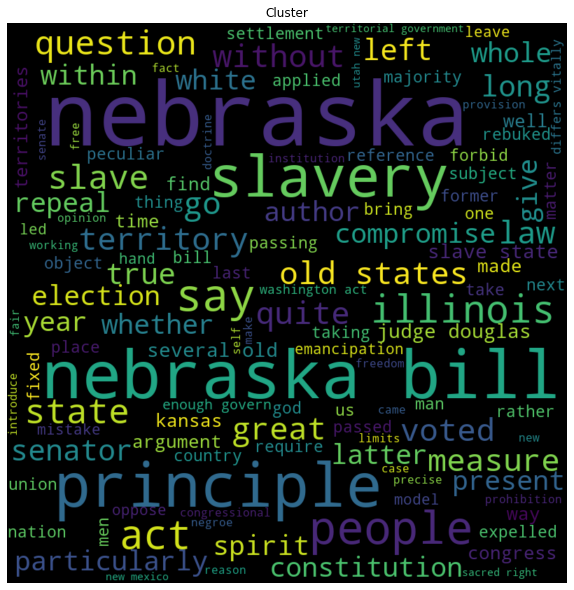

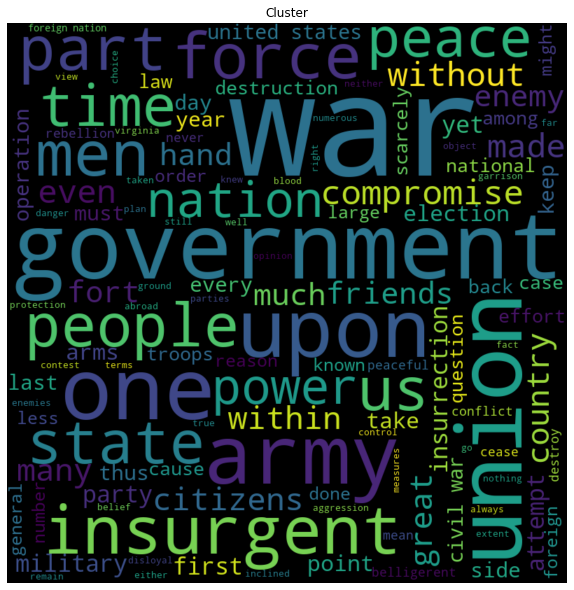

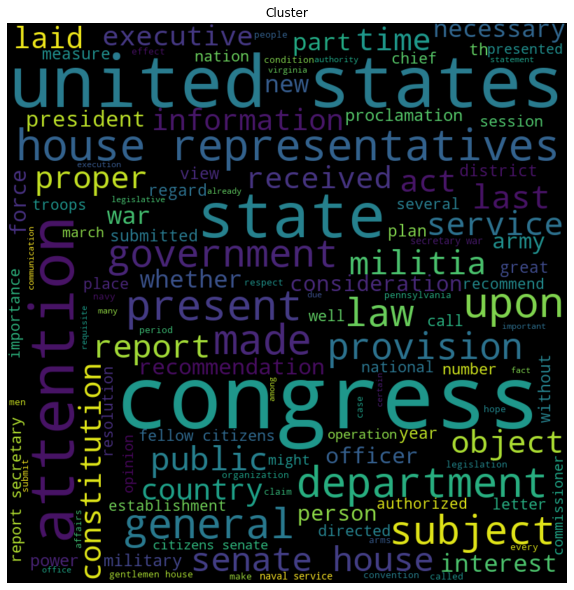

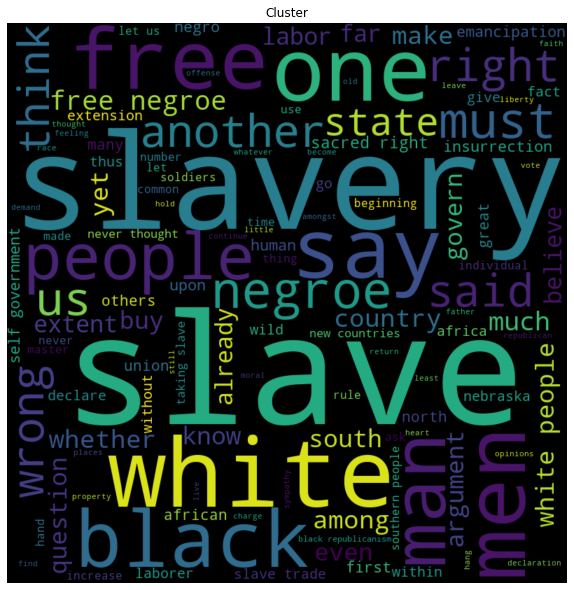

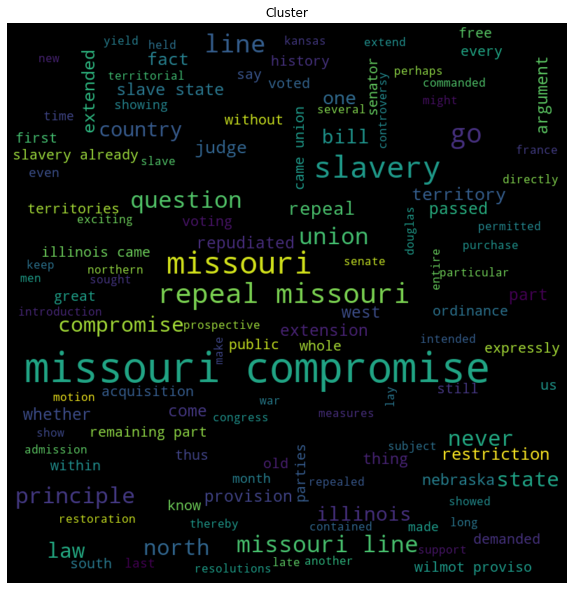

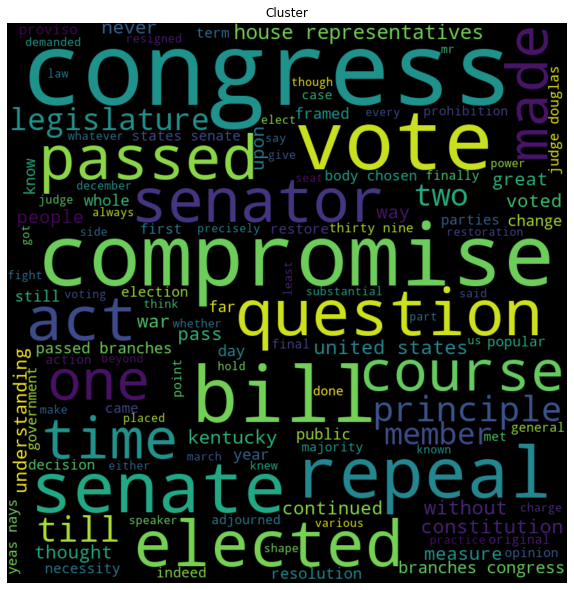

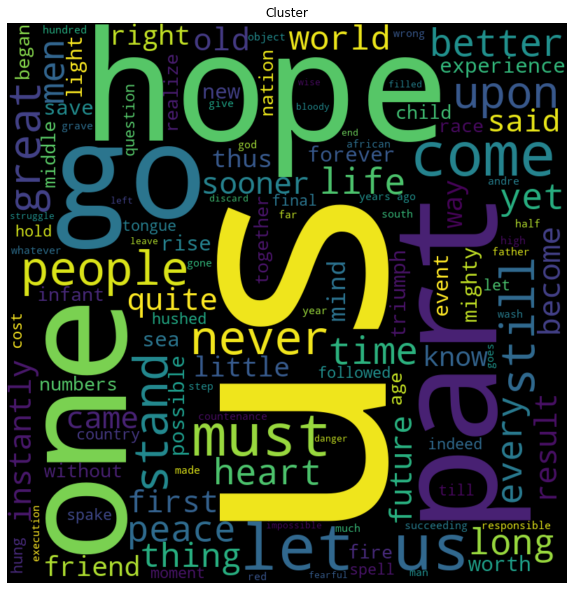

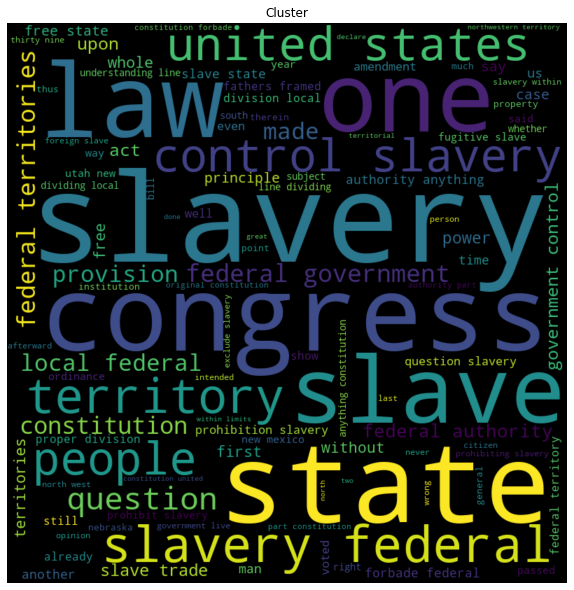

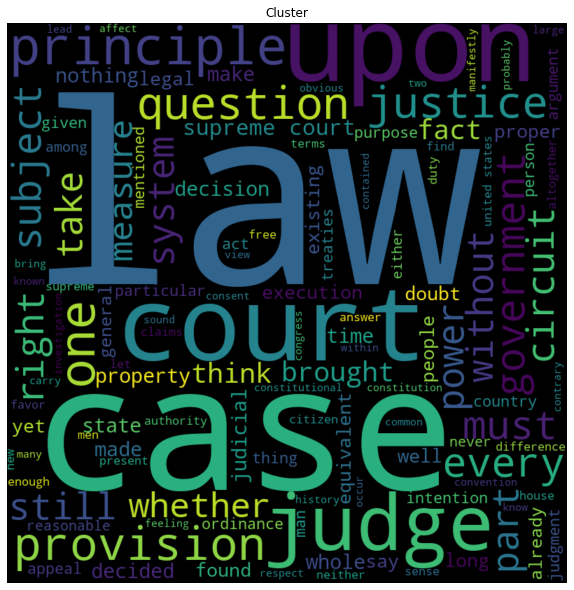

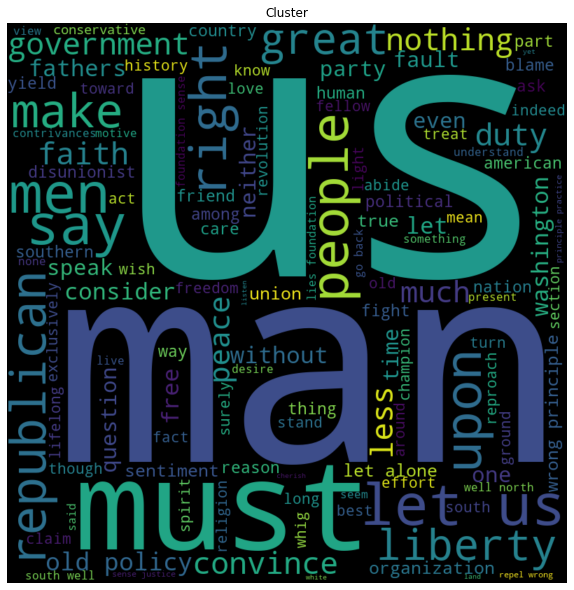

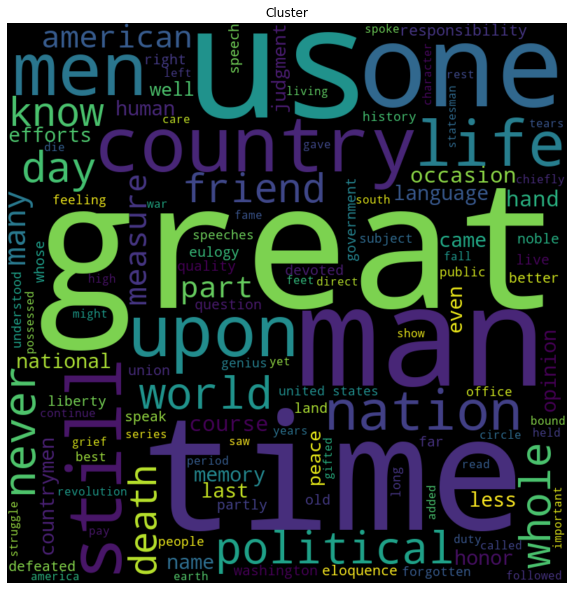

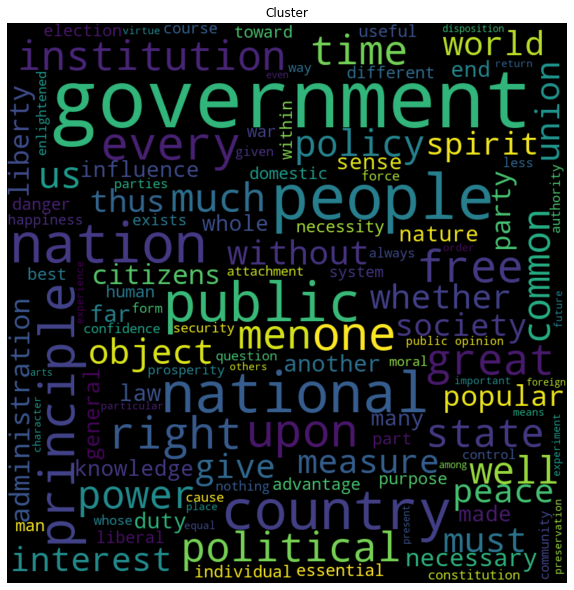

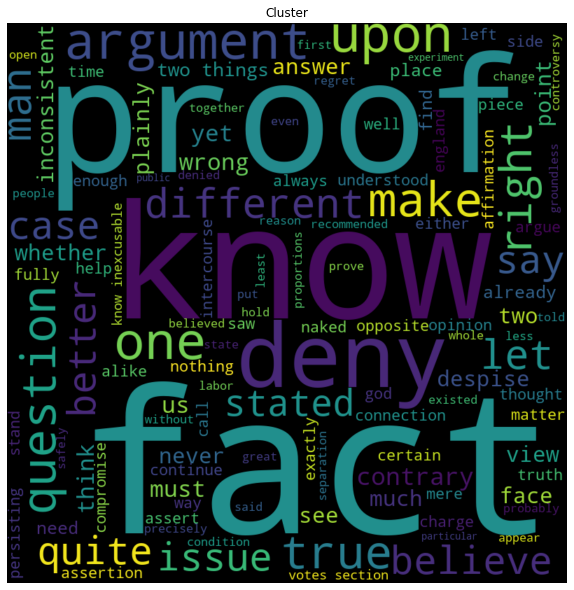

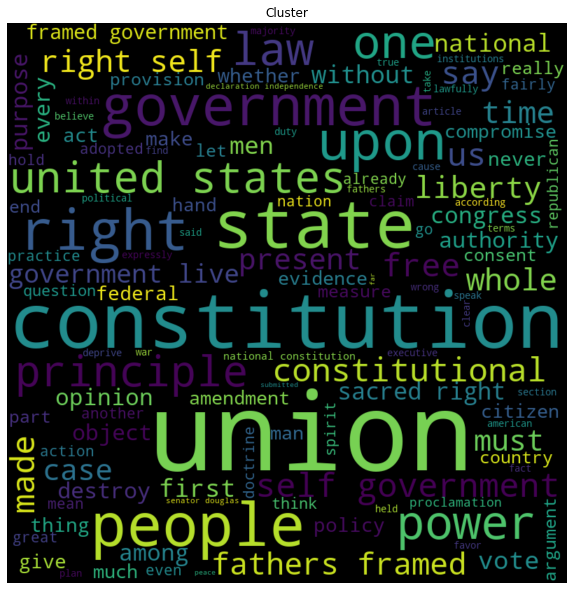

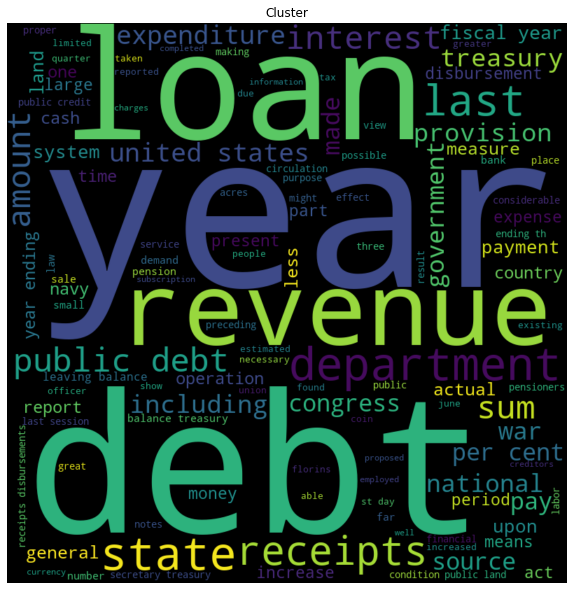

In [ ]:
# Word Cloud
#Original method - probably using this

# Add in when stop words is needed
additional_stopwords = ['may', 'will', 'good']
stop_words = set(stopwords.words('english'))
stop_words.update(additional_stopwords)

# List of tokenized sentences
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(post_cleanlab_sentences)

# Get the words and their tf-idf scores
feature_names = tfidf_vectorizer.get_feature_names_out()
scores = tfidf_matrix.toarray().mean(axis=0)

# Sort the words by their tf-idf scores
sorted_words = sorted(zip(feature_names, scores), key=lambda x: x[1])

# Print the 50 words with the lowest tf-idf scores
# print("50 words with the lowest tf-idf scores:")
# print(sorted_words[:50])
lowest_tfidf_words = []
for word, score in sorted_words[:50]:
    lowest_tfidf_words.append(word)
#     print(f"{word}: {score:.4f}")
print(lowest_tfidf_words)

#print(len(filteredTranscript))
#low_tfidf = lowest_tfidf_words(filteredTranscript)
#print(len(lowest_tfidf_words(filteredTranscript)))
#mask = np.array(Image.open('gw.png'))

for i in range(kmeans.n_clusters): # 10 clusters now
    # Get the indices of sentences belonging to the current cluster
    cluster_indices = np.where(labels == i)[0]
    cluster_sentences = [post_cleanlab_sentences[index] for index in cluster_indices]

    # Combine the sentences into a single string
    cluster_text = " ".join(cluster_sentences)
    cluster_text =" ".join([ word for word in cluster_text.split() if word.lower() not in (lowest_tfidf_words and stop_words)])
    # Generate a word cloud from the cluster text


    # wordcloud = WordCloud(min_font_size=4, 
    #                       mask=mask,
    #                       width=mask.shape[1],
    #                       height=mask.shape[0],
    #                       stopwords=lowest_tfidf_words, 
    #                       background_color="white",
    #                       contour_width=1,
    #                       contour_color="black")
    wordcloud = WordCloud(max_words=120, width=800, height=800, min_font_size=10).generate(cluster_text)
    wordcloud.generate(cluster_text)

    # Plot the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.title("Cluster".format(i))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

In [ ]:
# Rishabh Word Cloud method
# Try to implement filtering

#wcFolder = '/Data_output/'
clusterStrings = cluster_text
#centroids = cluster_centers

if 'result' in globals():
  print('yes')
else:
  #!wget http://nlp.stanford.edu/data/glove.6B.zip
  #!unzip glove*.zip
  #%ls
  url2 = 'http://nlp.stanford.edu/data/glove.6B.zip'
  os.system(f"""wget -c --read-timeout=5 --tries=0 "{url2}""")
  #To do: wget and unzip the file 
  glove_input_file = 'glove.6B.300d.txt'
  word2vec_output_file = 'word2vec.txt'
  # The first step is to convert the GloVe file format to the word2vec file format. 
  # The only difference is the addition of a small header line. This can be done by calling the 
  # glove2word2vec() function.

  glove2word2vec(glove_input_file, word2vec_output_file)
  model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
  # calculate: (king - man) + woman = ?
  result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
  print(result)


# Get the final coherence scores for each cluster

def calcFinalScores(coherenceScores, finalWeights):
  listScores = []
  for i in range(len(coherenceScores)):
    sum = 0
    for j in range(len(coherenceScores[i])):
      sum += finalWeights[i][j]*coherenceScores[i][j]
    listScores.append((sum*1000) / 45) # Multiply sum by 1000 to make scores more readable (this can be changed). Divide by 45 to get average. 
  return listScores


# Use temporary weights to get final weights. The weights will be finalized by normalizing them.

def calcFinalWeights(pairWeights):
  finalWeights = []
  for i in range(len(pairWeights)):
    curWeights = pairWeights[i]
    sumWeights = 0
    for j in range(len(curWeights)):
      # sumWeights = sumWeights + math.exp(curWeights[j])
      sumWeights = sumWeights + curWeights[j]
    tempFinalWeights = []
    for j in range(len(curWeights)):
      # tempFinalWeights.append(math.exp(curWeights[j]) / sumWeights)
      tempFinalWeights.append(curWeights[j] / sumWeights) # Normalize the weights
    finalWeights.append(tempFinalWeights)
  # sum = 0
  # for i in range(len(finalWeights[0])):
  #   sum = sum + finalWeights[1][i]
 
  return finalWeights

# This calculates the coherence score of each cluster
# The coherence is calculated by finding the pair-wise similarity between the top 10 words in the cluster.
# The top 10 words are determined using TF-IDF
# Final output will include intermediate scores and weights for the scores.
# Weigting is based on Zipf rank

def calcCoherence1(clusterStrings):
  corpus = clusterStrings # set corpus as the list of clusters with corresponding texts as strings
  # Use TF-IDF
  vectorizer = TfidfVectorizer(stop_words=STOPWORDS, norm=None, smooth_idf=False) 
  X = vectorizer.fit_transform(corpus)
  idf = vectorizer.idf_
  idf = idf - 1
  countVectorizer = CountVectorizer(stop_words=STOPWORDS)
  tf = countVectorizer.fit_transform(corpus)
  tf = tf.toarray()
  tfidf = tf*idf

  lemmatizer = WordNetLemmatizer()
  coherenceScores = []
  pairWeights = []

  for i in range(len(clusterStrings)): # loop through all clusters

    df = pd.DataFrame(tfidf[i], index=vectorizer.get_feature_names(), columns=["TF-IDF"])
    dfs = df.sort_values('TF-IDF', ascending=False) 

    curList = dfs.index.to_list()
    curListLem = []
    curList10 = []

    # Get top 10 words (lemmatized)
    w = 0
    c = 0
    while c < 10:
      word = curList[w]
      curWord = lemmatizer.lemmatize(word)
      if curWord not in curListLem and curWord in model.vocab:
        curListLem.append(curWord)
        c = c + 1
      w = w + 1

    # Get pair-wise scores
    tempScore = []
    tempPairWeights = []
    for a in range(len(curListLem)):
      for b in range(a, len(curListLem)):
        if a != b:
          w1 = curListLem[a]
          w2 = curListLem[b]
          weight1 = list(model.vocab.keys()).index(w1) # Get Zipf rank of word 1
          weight2 = list(model.vocab.keys()).index(w2) # Get Zipf rank of word 2
          tempPairWeights.append(mean([weight1, weight2]))
          # tempPairWeigts.append(math.log(weight1, 10) + math.log(weight2, 10) / 2)
          tempScore.append(model.similarity(w1, w2))
    pairWeights.append(tempPairWeights)
    coherenceScores.append(tempScore)
  return [pairWeights, coherenceScores] # return list of weights and temporary scores

# wrapper function to calculate coherence scores

def calcCoherence(clusterStrings):
  pairWeights_and_coherenceScores1 = calcCoherence1(clusterStrings)
  pairWeights = pairWeights_and_coherenceScores1[0]
  coherenceScores1 = pairWeights_and_coherenceScores1[1]
  finalWeights = calcFinalWeights(pairWeights)
  finalScores = calcFinalScores(coherenceScores1, finalWeights)
  return finalScores
calcCoherence(clusterStrings)

In [ ]:
# Running Cleanlab without z score removal
# Filters unrelated sentences from each individual speech

# Filtered speeches = list of every useful sentence across every speech of the selected president(s)
post_cleanlab_speeches = []
post_cleanlab_sentences = []

# Embedding and outlier removal
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

filtered_sent_percentages = []

for speech in pre_processed_speeches:
  try:
    ood = OutOfDistribution()
    original_embeddings = model.encode(speech)
    train_outlier_scores = ood.fit_score(features=original_embeddings)
    # get outlier id's for sentences with outlier scores below cutoff value
    outlier_ids = [i for i, outlier_score in enumerate(train_outlier_scores) if outlier_score < OUTLIER_SCORE_CUTOFF]

    if PRINT_CLEANLAB_ANALYSIS:
      filtered_sentences = [s for i, s in enumerate(speech) if i in outlier_ids]
      filtered_percent = round((len(filtered_sentences) / len(speech)) * 100) 
      filtered_sent_percentages.append(filtered_percent)

      print(f'Percentage of Sentences Filtered: {filtered_percent}%')
      print("Filtered Sentences:")
      for s in filtered_sentences:
        print(f'{s}')
      print("\n\n")

    speech = [s for i, s in enumerate(speech) if i not in outlier_ids]

    post_cleanlab_speeches.append(speech)
    for sentence in speech:
      post_cleanlab_sentences.append(sentence)
  except:
    continue

filtered_speech_embeddings = model.encode(post_cleanlab_sentences) # embedding

if PRINT_CLEANLAB_ANALYSIS:
  print(f'Unfiltered Speech Shape: {model.encode(pre_processed_speeches).shape}')
  print(f'Filtered Speech Shape: {filtered_speech_embeddings.shape}')

  print(f'Average percentage of filtered sentences per speech (cutoff value  of {OUTLIER_SCORE_CUTOFF}): {sum(filtered_sent_percentages) / len(filtered_sent_percentages)}')


Fitting OOD estimator based on provided features ...
Percentage of Sentences Filtered: 8%
Filtered Sentences:
it concerns myself  and will therefore be as brief as possible 
from this resolution i have in no instance departed 
Percentage of Sentences Filtered Z score: 100%
Filtered Sentences Z score:
fellow citizens of the senate and the house of representatives  among the vicissitudes incident to life  no event could have filled me with greater anxieties than that of which the notification was transmitted by your order  and received on the fourteenth day of the present month 
on the one hand  i was summoned by my country  whose voice i can never hear but with veneration and love  from a retreat which i had chosen with the fondest predilection  and  in my flattering hopes  with an immutable decision  as the asylum of my declining years  a retreat which was rendered every day more necessary as well as more dear to me  by the addition of habit to inclination  and of frequent interruption